In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from random import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,10

In [3]:
inputCSV = '../datasets/prepared/parking-prepared.csv';
data = pd.read_csv(inputCSV)

data['spots_available'] = pd.to_numeric(data['spots_available'])
data['verification_datetime'] = pd.to_datetime(data['verification_datetime'])
data = data.set_index('verification_datetime').asfreq('15min')

data.index = pd.DatetimeIndex(data.index, freq=data.index.inferred_freq)
data = data.dropna()

data['spots_available'] = (data['spots_available'] - data['spots_available'].shift(1))
data = data.dropna()

print(data)

                       spots_available
verification_datetime                 
2016-10-02 05:45:00               -2.0
2016-10-02 06:00:00                0.0
2016-10-02 06:15:00               -1.0
2016-10-02 07:00:00              -14.0
2016-10-02 07:45:00              -30.0
...                                ...
2017-04-21 22:00:00               62.0
2017-04-21 22:30:00              525.0
2017-04-21 23:00:00              152.0
2017-04-21 23:30:00               68.0
2017-04-21 23:45:00               36.0

[16218 rows x 1 columns]


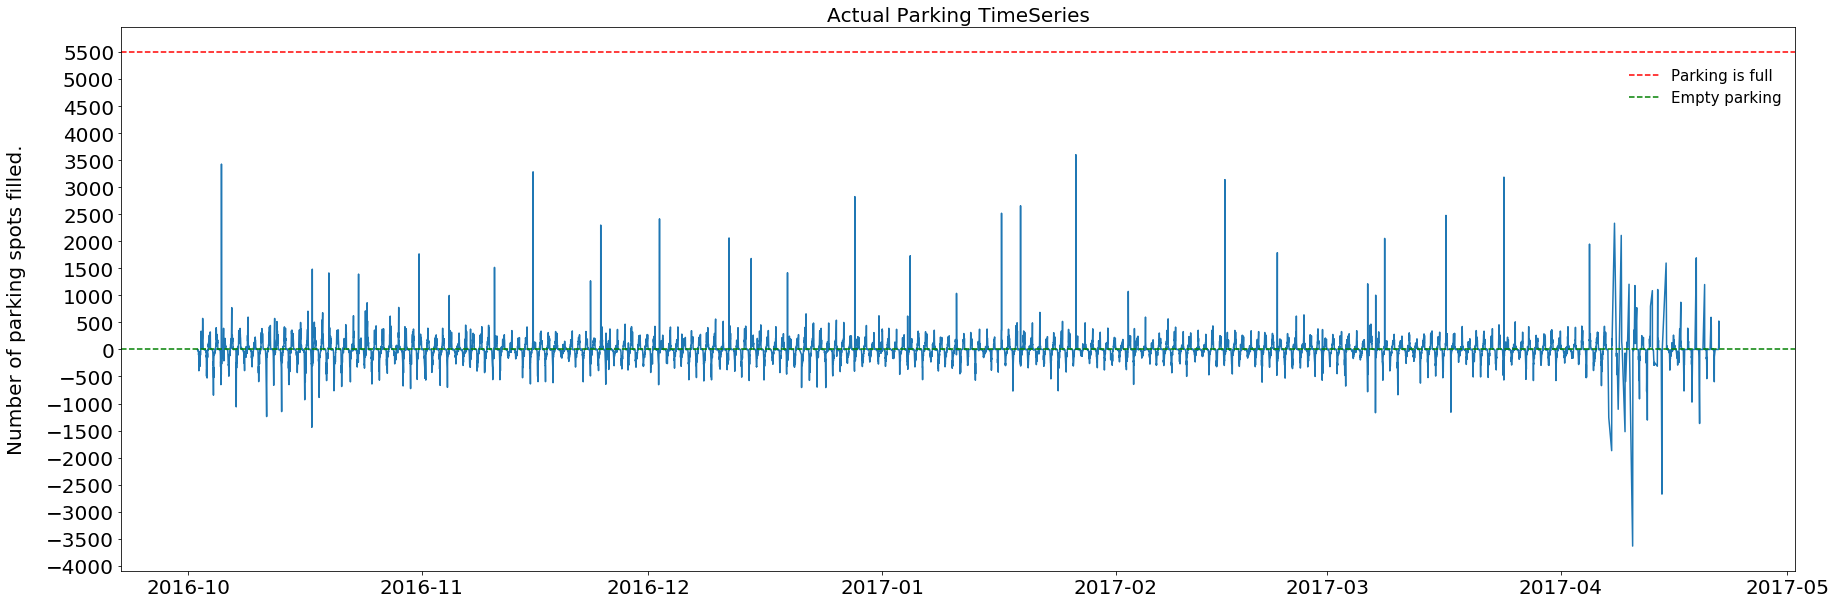

In [4]:
# Filter the dataset from the range of time with the minimun noise
prepared_data = data.copy()

#prepared_data = prepared_data[(prepared_data.index.to_series().dt.day >= 3) | (prepared_data.index.to_series().dt.month != 6)]

plt.tick_params(axis='both', which='major',  labelsize=20)
plt.ylabel('Number of parking spots filled.', labelpad=20,  fontsize=20)

#plt.plot(y=5500, color='r', linestyle='dashed')
plt.title("Actual Parking TimeSeries", fontsize=20)
plt.plot(prepared_data)

plt.locator_params(axis='y', nbins=21)
plt.axhline(y=5500, color='r', linestyle='--', label="Parking is full")
plt.axhline(y=0, color='g', linestyle='--', label="Empty parking")
plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 0.95), prop={'size': 15})

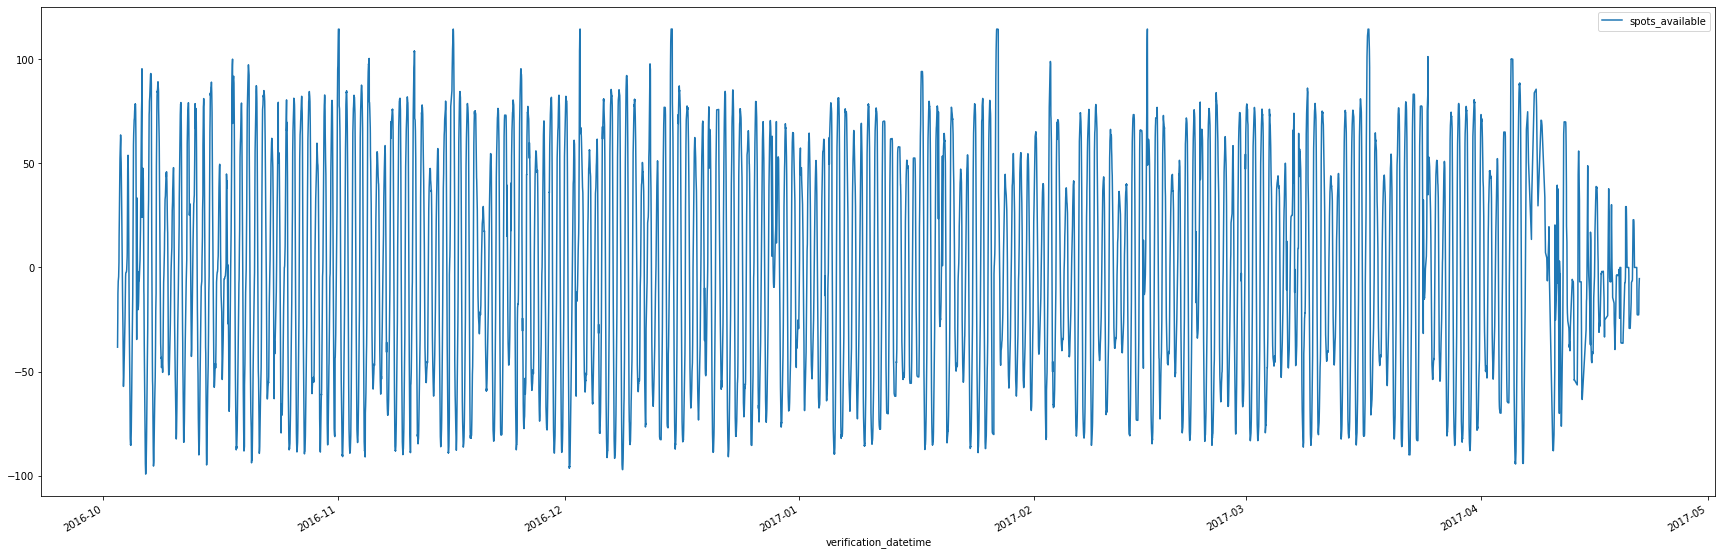

In [5]:
data_mean = data.rolling(window = 48*1).mean()
data_mean = data_mean.dropna()
data_mean.plot()

In [6]:
data_mean.describe()

,spots_available
count,16171.000000
mean,-0.179145
std,54.515503
min,-99.291667
25%,-48.229167
50%,-2.208333
75%,49.708333
max,114.583333


In [7]:
data.describe()

,spots_available
count,16218.000000
mean,-0.257368
std,172.646583
min,-3635.000000
25%,-45.000000
50%,0.000000
75%,51.000000
max,3600.000000


In [8]:
series_value = data_mean.copy()
series_value = series_value.values
value = pd.DataFrame(series_value)

park_df = pd.concat([value,value.shift(1)],axis=1)
park_df.head()

,0,0
0,-38.312500,NaN
1,-34.333333,-38.312500
2,-29.937500,-34.333333
3,-24.666667,-29.937500
4,-12.416667,-24.666667


In [9]:
park_df.columns = ['actual','forecast']
park_df = park_df.dropna()
park_df.head()

,actual,forecast
1,-34.333333,-38.312500
2,-29.937500,-34.333333
3,-24.666667,-29.937500
4,-12.416667,-24.666667
5,-7.145833,-12.416667


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [11]:
park_error = mean_squared_error( park_df.actual, park_df.forecast )
park_error

32.5364782497595

In [12]:
np.sqrt(park_error)

5.704075582402419

In [13]:
data_mean

,spots_available
verification_datetime,
2016-10-02 21:15:00,-38.312500
2016-10-02 21:30:00,-34.333333
2016-10-02 21:45:00,-29.937500
2016-10-02 22:00:00,-24.666667
2016-10-02 22:30:00,-12.416667
...,...
2017-04-21 22:00:00,-21.604167
2017-04-21 22:30:00,-10.687500
2017-04-21 23:00:00,-7.500000


In [14]:
from statsmodels.tsa.ar_model import AutoReg

#data_mean['verification_datetime'] = pd.to_datetime(data_mean['verification_datetime'])
data_mean = data_mean.set_index(data_mean.index).asfreq('15min')
data_mean.index = pd.DatetimeIndex(data_mean.index)
data_mean = data_mean.dropna()

predict_days = 30

model = AutoReg(data_mean, lags=96*2, period=96)
model_fit = model.fit()

yhat = model_fit.predict(start=len(data_mean), end=len(data_mean)+predict_days*96)

print("Predict Parking Spots Available for Next 90 Days:")
print(yhat)

print("\nMin Value:",yhat.min())
print("Max Value:",yhat.max())

print("\nDone!")

C:\Users\lrmen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\lrmen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Predict Parking Spots Available for Next 90 Days:
16171   -4.568527
16172   -4.552187
16173   -4.406515
16174   -4.878903
16175   -3.527091
           ...   
19047   -0.233388
19048   -0.219876
19049   -0.206151
19050   -0.192289
19051   -0.178365
Length: 2881, dtype: float64

Min Value: -35.53601523599882
Max Value: 41.78722888457558

Done!


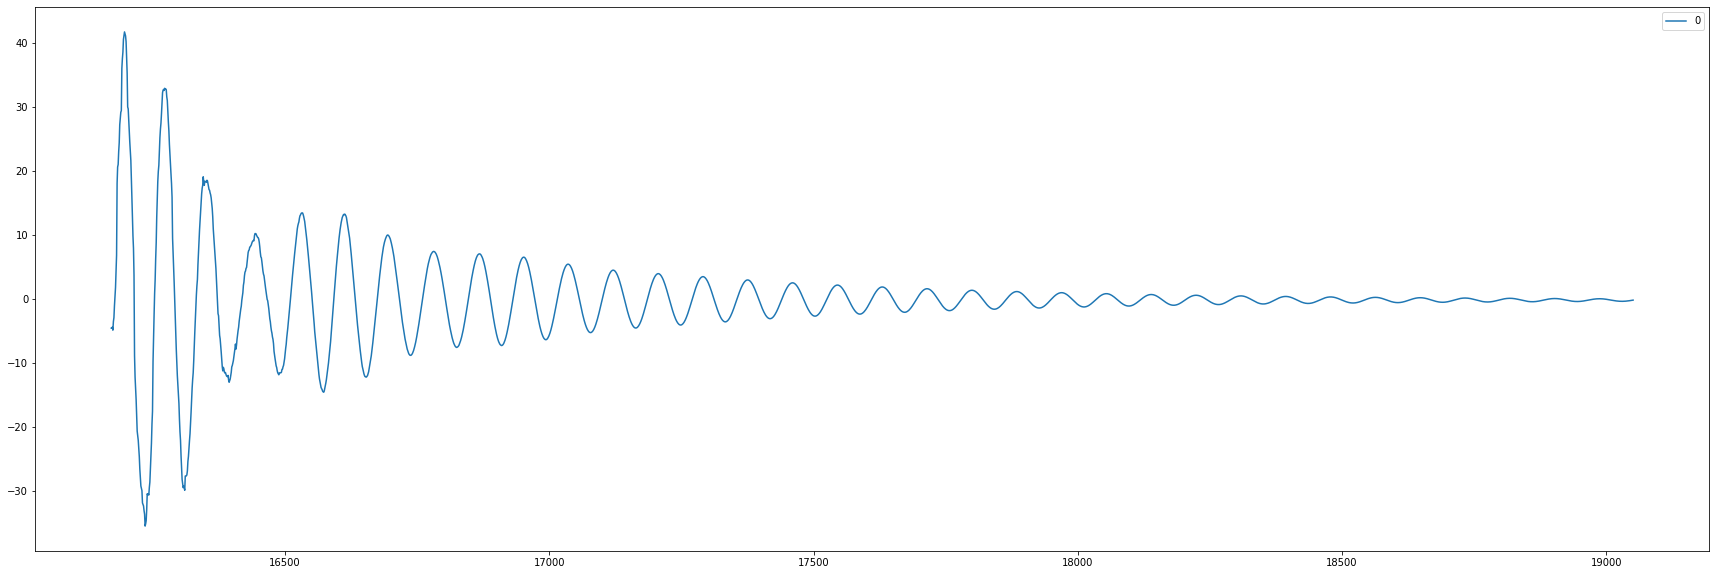

In [15]:
data_final = pd.DataFrame(yhat)
data_final.plot()

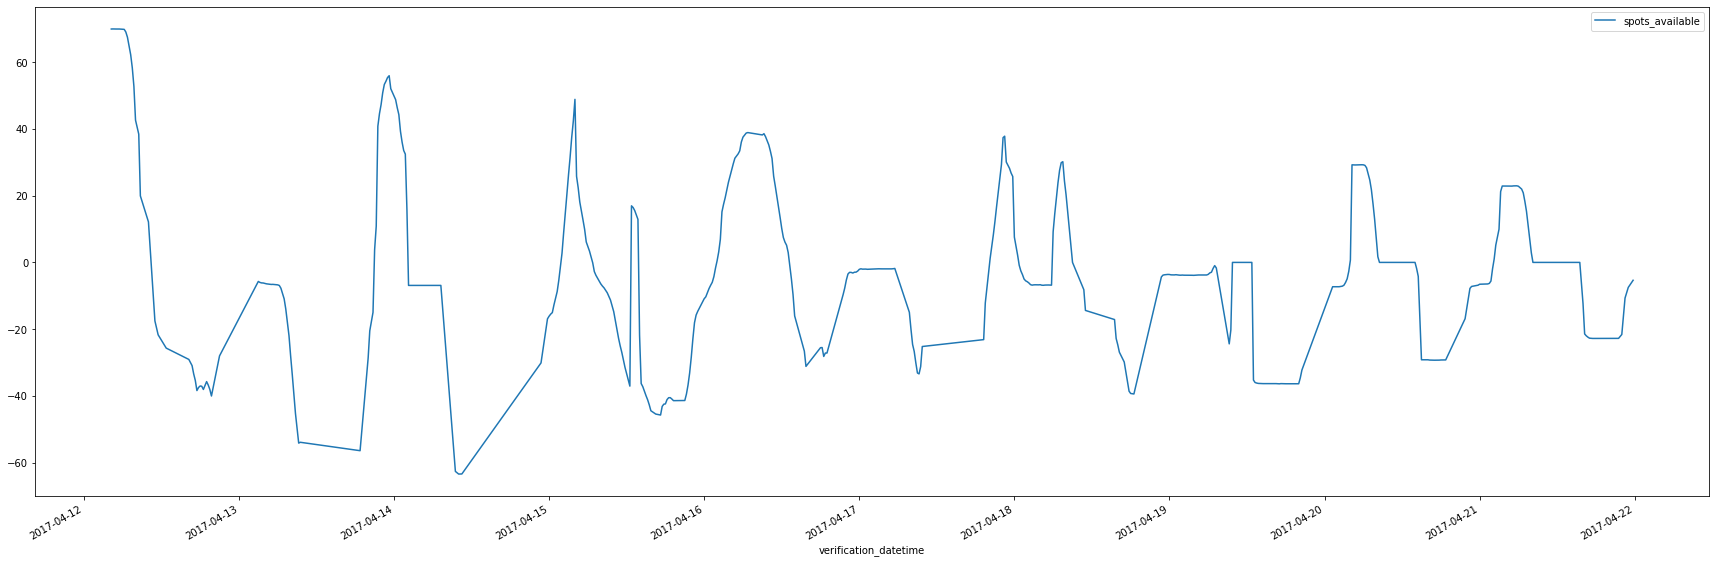

In [16]:
data_mean[-500:].plot()

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

16218  -  12163  -  3960


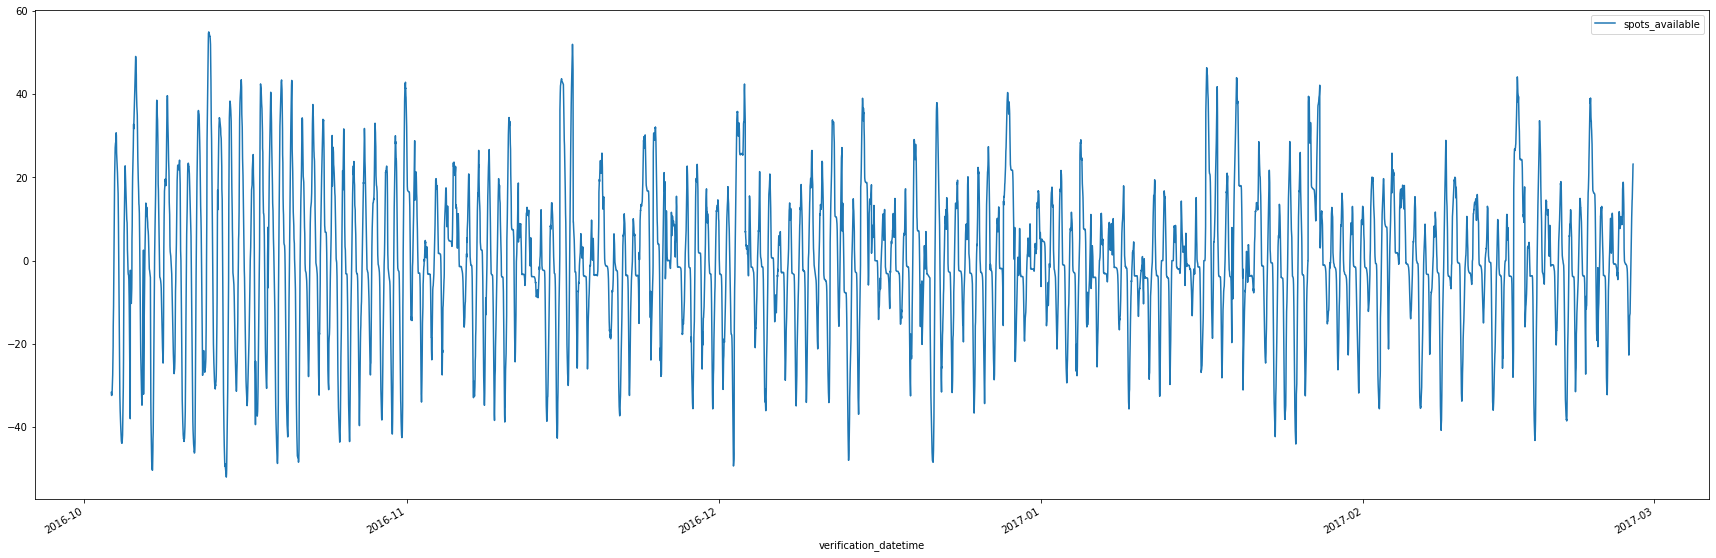

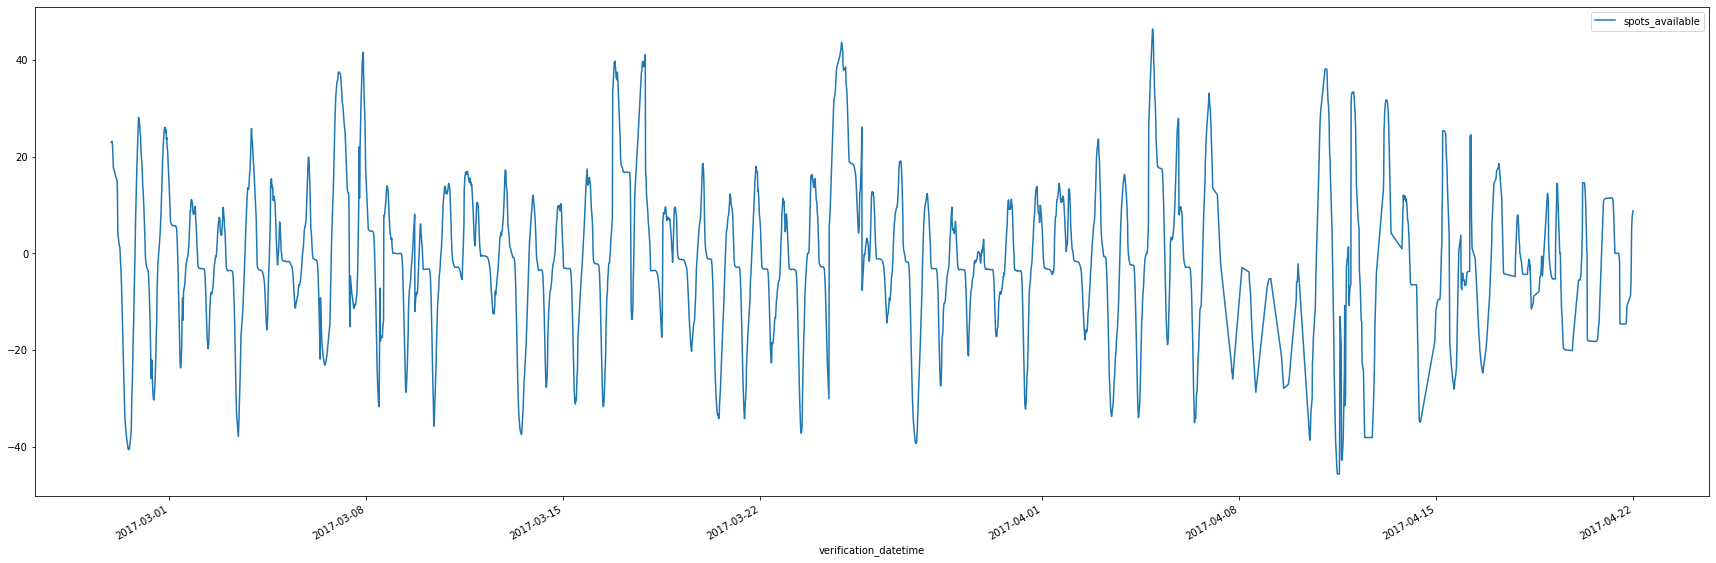

In [112]:
# p = 10,15
# d = 0
# q = 18,22

data_mean = data.copy()
data_mean = data.rolling(window = 96*1).mean()
data_mean = data_mean.dropna()

train,test = data_mean[0:12163], data_mean[12163:]

print(data.size, " - ",train.size," - ",test.size)

train.plot()
test.plot()

In [131]:
from statsmodels.tsa.arima_model import ARIMA

print("Running")
park_model = ARIMA(train, order=(2,0,2))
print("Running 2")
park_model_fit = park_model.fit()
print(park_model_fit.aic)
print("END")

Running
Running 2


C:\Users\lrmen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


49812.209989582
END


In [132]:
park_forecast = park_model_fit.forecast(steps = 3960)[0]
park_forecast

array([2.32737258e+01, 2.31405720e+01, 2.28224371e+01, ...,
       1.19328027e-02, 1.19328027e-02, 1.19328027e-02])

In [133]:
final_data = pd.DataFrame(park_forecast)
final_data

,0
0,23.273726
1,23.140572
2,22.822437
3,22.336380
4,21.699551
...,...
3955,0.011933
3956,0.011933
3957,0.011933
3958,0.011933


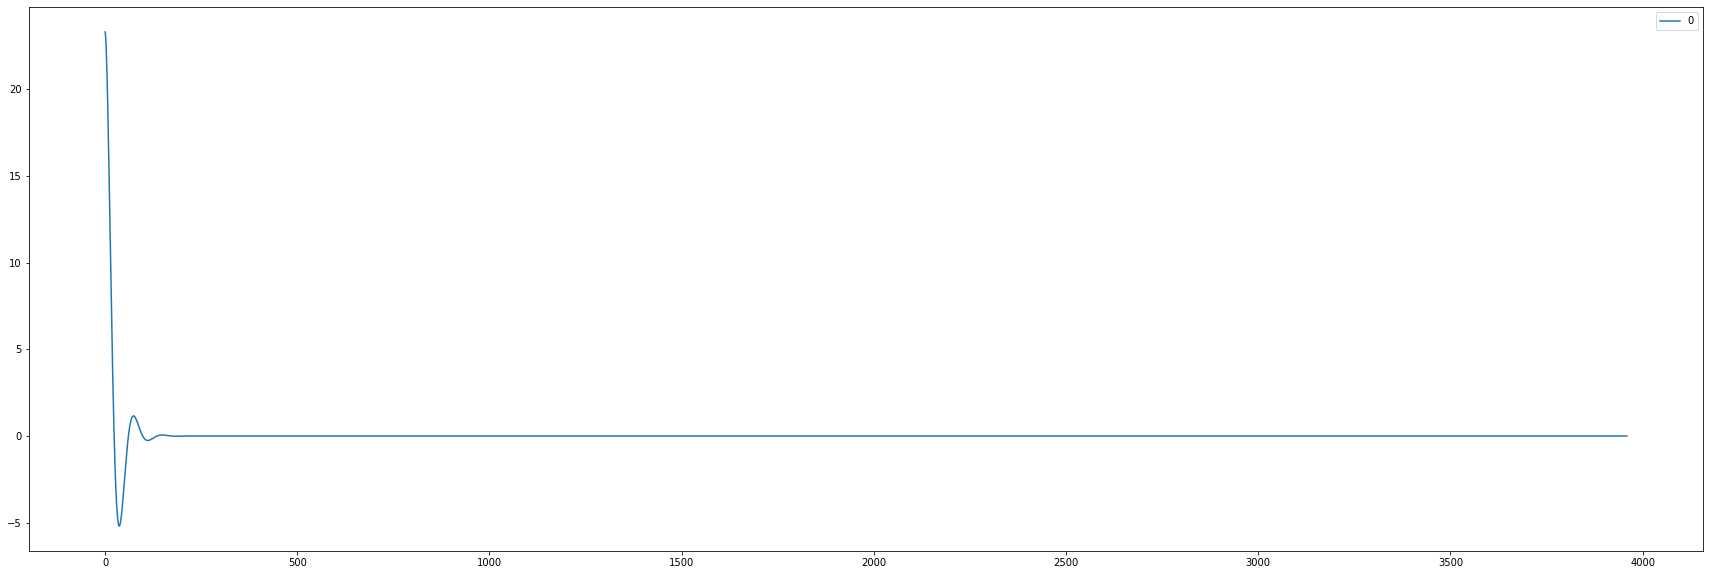

In [134]:
final_data.plot()

In [135]:
np.sqrt(mean_squared_error(test,park_forecast))

15.543819969020507